In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import  train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score

In [126]:
def is_outlier(_X):
    return LocalOutlierFactor().fit_predict(_X)
   
def remove_outliers(_X, _y):
    tmp = _X[_y == 1, :]
    _X0 = tmp[is_outlier(tmp) == 1, :]
    tmp = _X[_y == 2, :]
    _X1 = tmp[is_outlier(tmp) == 1, :]
    tmp = _X[_y == 3, :]
    _X2 = tmp[is_outlier(tmp) == 1, :]
    return _X0, _X1, _X2

def select_features(clf, _X, _y):
    rfecv = RFECV(estimator=clf, scoring='accuracy', cv=5)
    rfecv.fit(_X, _y)
    
    print("Optimal number of features : %d" % rfecv.n_features_)
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    X_fe=_X[:, rfecv.ranking_ == 1]
    print(X_fe.shape)
    return X_fe, rfecv

In [127]:
df_train = pd.read_csv('train.csv', sep=';', header=None)
feature_n = df_train.columns.size - 1
object_n = df_train.index.size

X = df_train.iloc[:, 0 : feature_n].values
print(X.shape)
y = df_train.iloc[:, feature_n].values
for i in range(feature_n):
    x = X[:, i]
    mi = np.min(x)
    ma = np.max(x)
    for j in range(object_n):
        if ma - mi == 0:
            x[j] = 0.5
        else:
            x[j] = (x[j] - mi) / (ma - mi)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
svc = SVC(kernel='linear')

(560, 432)
(280, 432) (280, 432) (280,) (280,)


Optimal number of features : 55
(280, 55)
(280, 55) (240, 55) (240,)


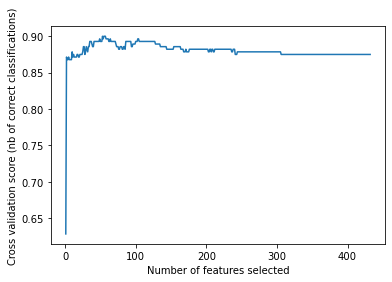

In [128]:
X_fe, rfecv_od = select_features(svc, X_train, y_train)
X0_fe_od, X1_fe_od, X2_fe_od = remove_outliers(X_fe, y_train)
X_fe_od = np.vstack([X0_fe_od, X1_fe_od, X2_fe_od])
y_fe_od = np.hstack([
    np.full(X0_fe_od.shape[0], 1),
    np.full(X1_fe_od.shape[0], 2),
    np.full(X2_fe_od.shape[0], 3)
])
print(X_fe.shape, X_fe_od.shape, y_fe_od.shape)

(235, 432) (235,)
Optimal number of features : 21
(235, 21)


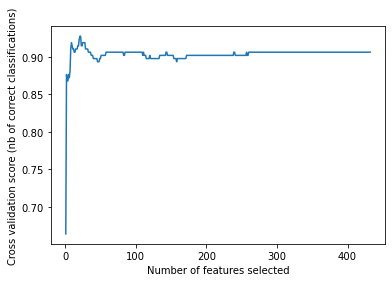

In [129]:
X0_od, X1_od, X2_od = remove_outliers(X_train, y_train)
X_od = np.vstack([X0_od, X1_od, X2_od])
y_od_fe = np.hstack([
    np.full(X0_od.shape[0], 1), 
    np.full(X1_od.shape[0], 2), 
    np.full(X2_od.shape[0], 3)
])

print(X_od.shape, y_od_fe.shape)
X_od_fe, od_rfecv = select_features(svc, X_od, y_od_fe)

In [130]:
#without fe and od
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.8821428571428571


In [131]:
# fe -> od
svc.fit(X_fe_od, y_fe_od)
y_fe_od_pred = svc.predict(X_test[:, rfecv_od.ranking_ == 1])
print(accuracy_score(y_test, y_fe_od_pred))

0.8428571428571429


In [132]:
# od -> fe
svc.fit(X_od_fe, y_od_fe)
y_od_fe_pred = svc.predict(X_test[:, od_rfecv.ranking_ == 1])
print(accuracy_score(y_test, y_od_fe_pred))


0.85


In [133]:
# в RFECV используется SVC, который чувствителен к шумовым данным, 
# поэтому я считаю, что правильнее делать od->fe. Экспериментальные данные подтвердили эту теорию

In [134]:
from sklearn.neighbors import KNeighborsClassifier as KNN
knn = KNN(metric='euclidean', n_neighbors=26)

# неочищенные
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test, y_pred))

# fe->od
knn.fit(X_fe_od, y_fe_od)
y_fe_od_pred = knn.predict(X_test[:, rfecv_od.ranking_ == 1])
print(accuracy_score(y_test, y_fe_od_pred))

#od->fe
knn.fit(X_od_fe, y_od_fe)
y_od_fe_pred = knn.predict(X_test[:, od_rfecv.ranking_ == 1])
print(accuracy_score(y_test, y_od_fe_pred))

0.7428571428571429
0.7964285714285714
0.8357142857142857


In [135]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)

# неочищенные
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(accuracy_score(y_test, y_pred))

#fe->od
dt.fit(X_fe_od, y_fe_od)
y_fe_od_pred = dt.predict(X_test[:, rfecv_od.ranking_ == 1])
print(accuracy_score(y_test, y_fe_od_pred))

#od->fe
dt.fit(X_od_fe, y_od_fe)
y_od_fe_pred = dt.predict(X_test[:, od_rfecv.ranking_ == 1])
print(accuracy_score(y_test, y_od_fe_pred))

0.9392857142857143
0.8107142857142857
0.875


In [136]:
svc = SVC(kernel='poly')
# неочищенные
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(accuracy_score(y_test, y_pred))

#fe->od
svc.fit(X_fe_od, y_fe_od)
y_fe_od_pred = svc.predict(X_test[:, rfecv_od.ranking_ == 1])
print(accuracy_score(y_test, y_fe_od_pred))

#od->fe
svc.fit(X_od_fe, y_od_fe)
y_od_fe_pred = svc.predict(X_test[:, od_rfecv.ranking_ == 1])
print(accuracy_score(y_test, y_od_fe_pred))

0.8821428571428571
0.8428571428571429
0.8607142857142858


In [137]:
# Для работы с неочищенными данными лучше всего пригоден DT
# На очищенных данных лучше других снова стал DT, однако в среднем лучше себя показал SVC,
# т.к. большое количество признаков не является проблемой для SVC 
# и, как следствие, он показывает лучшие усредненные результаты после работы fe